In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def train_test_val_split(x, y, random_state=None, split=[0.6, 0.2, 0.2]):
  """
    Runs the train test split twice to break data up into train, validation and test sets at ratios specified by
    split
  """
  x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size=1-split[0], random_state=random_state)
  x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=split[1]/(split[1]+split[2]), random_state=random_state)
  return x_train, x_val, x_test, y_train, y_val, y_test


# Data

In [24]:
df = pd.read_csv("HW5_data.csv")
x = df[["X", "Y"]].values
y = df.Z.values
df.head()

,Unnamed: 0,X,Y,Z
0,0,7.324518,3.657837,1693.658572
1,1,7.838516,8.214597,46111.249973
2,2,7.149941,0.078071,806.812388
3,3,6.812724,9.404818,88997.210710
4,4,5.568275,9.288328,83263.340975


In [ ]:
df.describe()

,Unnamed: 0,X,Y,Z
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,5.086919,5.126541,20804.621633
std,288.819436,2.971258,2.832314,29695.495028
min,0.000000,0.002513,0.016461,5.239307
25%,249.750000,2.289596,2.726231,1025.555492
50%,499.500000,5.160793,5.285917,5683.968424
75%,749.250000,7.750959,7.536397,29508.246037
max,999.000000,9.986307,9.995078,120302.221250


The data is split into training, validation and test sets with ratios $0.6:0.2:0.2$ 

In [56]:
x_train, x_val, x_test, y_train, y_val, y_test = train_test_val_split(x, y)
print("Training size")
print(x_train.shape)
print("Validation size")
print(x_val.shape)
print("Test size")
print(x_test.shape)

Training size
(600, 2)
Validation size
(200, 2)
Test size
(200, 2)


# Model

We are told to apply a polynomial transformation on the features and use linear regression to obtain the optimal coefficients of the polynomial fit. We create a simple pipeline to achieve this. The only hyperparameter is the maximal degree of the polynomial feature map. The feature map ignores the bias but the linear regressor does not which correctly accounts for the data not being centered. 

In order to tune the degree hyperparameter we sweep the parameter space and compute the MSE on the unseen validation set we had created. I am assuming the question does not require anything beyond this simple approach.

In [72]:
def poly_fit_pipeline(degree):
  polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
  pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", LinearRegression())])
  return pipeline

degrees = [2,3,4,5,6,7]
mse = []

for d in degrees:
  model = poly_fit_pipeline(d)
  model.fit(x_train, y_train)
  y_pred = model.predict(x_val)
  mse.append(mean_squared_error(y_pred, y_val))

Lowest validation MSE: 0.009
Optimal degree: 6


Text(0.5, 0, 'D')

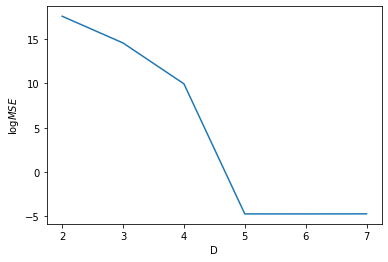

In [73]:
print("Lowest validation MSE: "+str(round(np.min(mse),3)))
print("Optimal degree: "+str(degrees[np.argmin(mse)]))
plt.figure()
plt.plot(degrees, np.log(mse))
plt.ylabel(r"$\log MSE$")
plt.xlabel("D")

In [79]:
model_optimal = poly_fit_pipeline(6)
model_optimal.fit(x_train, y_train)
mse_train = mean_squared_error(y_train, model.predict(x_train))
print("Training MSE: "+str(mse_train))
mse_val = mean_squared_error(y_val, model.predict(x_val))
print("Validation MSE: "+str(mse_val))
mse_test = mean_squared_error(y_test, model.predict(x_test))
print("Test MSE: "+str(mse_test) )

Training MSE: 0.008621014128936854
Validation MSE: 0.00895723100171667
Test MSE: 0.009421933878894272


The optimization over the hyperparameter space indicates that a maximal degree of $6$ is optimal. Notice that the difference between a degree 5 fit and a degree 6 fit is miniscule so one could also go with the less complex model that offers very similar accuracy. We'll stick with $D=6$ though.

## Details of the optimal model

In [82]:
print("Model parameters")
print(model_optimal.get_params())
print("regression coefficients")
print(model_optimal['linear_regression'].coef_)
print("regression intercept")
print(model_optimal['linear_regression'].intercept_)


Model parameters
{'memory': None, 'steps': [('polynomial_features', PolynomialFeatures(degree=6, include_bias=False, interaction_only=False,
                   order='C')), ('linear_regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))], 'verbose': False, 'polynomial_features': PolynomialFeatures(degree=6, include_bias=False, interaction_only=False,
                   order='C'), 'linear_regression': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 'polynomial_features__degree': 6, 'polynomial_features__include_bias': False, 'polynomial_features__interaction_only': False, 'polynomial_features__order': 'C', 'linear_regression__copy_X': True, 'linear_regression__fit_intercept': True, 'linear_regression__n_jobs': None, 'linear_regression__normalize': False}
regression coefficients
[ 8.50234361e-01  9.62565178e-01  2.44544103e-01 -2.94295566e+00
  5.06385541e-03  2.24830034e-03  4.74477640e-01  9.21766117e-04
 -1.47698